# Price Taker Class Example

This file walks through the construction of a price-taker model for a solid oxide fuel cell (SOFC) evaluated within the ERCOT West, 2022 price market.

## Imports

The first cell imports all necessary functions. Notably, we need the FlowsheetBlock from idaes.core, the DesignModel and OperationModel from the multiperiod class, and the PriceTakerModel, also from the multiperiod class.

In [1]:
import pyomo.environ as pyo

from idaes.core import FlowsheetBlock
# from idaes.apps.grid_integration.multiperiod.price_taker_model import PriceTakerModel
from idaes.apps.grid_integration.pricetaker.price_taker_model import PriceTakerModel

from idaes.apps.grid_integration.pricetaker.design_and_operation_models import (
    DesignModel,
    OperationModel,
)
#from idaes.apps.grid_integration import DesignModel, OperationModel
## ?? check if the multiperiod current version hose the price taker model
##??? is configurationerror needed
# from idaes.core.util.exceptions import ConfigurationError

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pathlib import Path
import os.path

###################
# import idaes.logger as idaeslog
# from idaes.apps.grid_integration import DesignModel, OperationModel
# from idaes.apps.grid_integration.pricetaker.price_taker_model import PriceTakerModel
# from idaes.apps.grid_integration.pricetaker.unit_commitment import UnitCommitmentData

# pylint: disable = unused-import
# from idaes.apps.grid_integration.pricetaker.tests.test_clustering import (
  #   dummy_data_fixture,
    # sklearn_avail,
# )
# from idaes.core.util.exceptions import ConfigurationError

The following is to check package import, which is not needed for actual running the code
when there's error from importing
1. check idaes version up-to-date or not, and restart kernel
2. check github example code about the exact line
3. check if the folder for the import module/function exist

In [2]:
# import idaes
# print(idaes.__version__)
# from idaes.apps.grid_integration.pricetaker.price_taker_model import PriceTakerModel
# import idaes.apps.grid_integration as gi
# print(dir(gi))

# Model Block components

## simple_flowsheet_func(m):
Dummy flowsheet function for testing

needed for m.build_multiperiod_model()

In [3]:
def simple_flowsheet_func(m):
    """Dummy flowsheet function for testing"""
    m.x = pyo.Var()
    m.y = pyo.Var()
    m.con1 = pyo.Constraint(expr=m.x + m.y == 1)
    m.LMP = pyo.Param(initialize=1, mutable=False)

    m.blk = pyo.Block()
    m.blk.power = pyo.Var()
    m.blk.op_mode = pyo.Var(within=pyo.Binary)
    m.blk.LMP = pyo.Param(initialize=1, mutable=False)


## Design Block

To utilize to price taker class, we first need to establish a design model and an operational model. First we will discuss the design model. The design model contains upper-level decisions that dictate whether the model is used, what maximum and minimum capacity for a commodity, and other relevant decisions. The two variables mentioned here will be used in the function below.

In this example, we utilize an hourly version of capital expenditures (CAPEX) and fixed operating and investment costs (FOM). However, we include them to be \$0.00 here for completeness.

In [4]:
def SOFC_design_model(
    m,
    max_power=None,
    min_power=None,
):
    # Capacity parameters; Minimum and Maximum power capacity given by the user
    m.PMAX = pyo.Param(initialize=max_power, mutable=False)
    m.PMIN = pyo.Param(initialize=min_power, mutable=False)
    m.capacity = pyo.Var()      
    m.install_unit = pyo.Var(initialize=1)
    m.install_unit.fix(1)
    # Binary variable to decide whether to build the unit or not.
    # In this example, we fix the value to 1 to ensure the unit is built.    # this is not in the new code m.build_unit = pyo.Param(initialize=1, mutable=False)


    # DesignModel automatically declares install_unit variables
    m.low_capacity_limit = pyo.Constraint(expr=m.PMIN * m.install_unit <= m.capacity)
    m.up_capacity_limit = pyo.Constraint(expr=m.capacity <= m.PMAX * m.install_unit)

    # Capital investment cost ($) --> We will be using hourly cash flows in the operational model
    m.capex = 70.37 * 1e6
    # Fixed operating and investment ($ / year) --> We will be using hourly cash flows in the operational model.
    m.fom = 49 * 1e6
    

## Operational block

The operational block represents the model that is to be "discretized" in time to accomodate temporal price signals. The price taker model utilizes the multiperiod model class to generate a block-structure model for each time period. 

An SOFC only produces power, so there is a power variable in each period for power generated at time $t$. Also, there are fuel consumption and variable costs associated with producing units of power. In this model, we use a linear surrogate to approximate fuel cost. There is a nonlinear surrogate option included as well, but we have commented this line out to remain as a mixed-integer, linear programming (MILP) problem.

There are two sources of revenue that we have analyzed in the past (Hydrogen ($H_2$) and power). For power, we take the hourly production multiplied by the locational marginal price (LMP) at time $t$. As noted earlier, the SOFC only produces power, so the revenue from $H_2$ is 0. Other costs may include non-fuel variable costs and carbon tax. For this example, we have left these options in the code but the values are 0 as non-fuel vom has been included in fuel cost and carbon tax is 0 $\$\cdot$ tonne $^{-1}$ for the ERCOT WEST, 2022 market.

Finally, we include fixed cost (CAPEX and FOM) at an hourly rate (see design model description above).

There are three binary variables associated with the operational block. They are {"op_mode", "startup", "shutdown"}. "op_mode" is a binary variable that is 1 if the system is on and 0 if the system is off. "startup" indicates that the system starts up at time $t$ (i.e., "op_mode" was off at time $t-1$ and is on at time $t$). "shutdown" indicates that the system shuts down at time $t$ (i.e., "op_mode" was on at time $t-1$ and is off at time $t$). The startup and shutdown procedures cost money each time they are chosen, and this is the final cost line in the function.

In [5]:
def SOFC_operation_model(
    m,
    sofc_design_blk=None,
):
    # Operation Variables
    m.power = pyo.Var(domain=pyo.NonNegativeReals)

    # Linear version of surrogate cost constraint (combined fuel_cost and non_fuel_vom)
    m.fuel_cost = pyo.Expression(expr=(23.2934 * m.power + 49.21504))
    # Nonlinear version of surrogate cost constraint (combined fuel_cost and non_fuel_vom)
    # m.fuel_cost = aml.Expression(expr=(23.2934 * m.power + 0.287571e-3 * m.power ** 2 + 0.1155903e-5 * m.power ** 3 + 49.21504))
    
    m.elec_revenue = pyo.Expression(expr=(m.power * m.LMP))
    m.H2_revenue = pyo.Expression(expr=(0))
    m.non_fuel_vom = pyo.Expression(expr=(0))
    m.carbon_price = pyo.Expression(expr=(0))

    fixed_cap_hourly = 70.37 * 1e6 / 365 / 24
    fixed_op_hourly = 49.53 * 1e6 / 365 / 24
    ## ？？ movw the above two lines to build_sofc_flowsheet? after m.op_blk as the example code
    
    m.hourly_fixed_costs = pyo.Expression(expr=(fixed_cap_hourly + fixed_op_hourly))
    m.su_sd_costs = pyo.Expression(expr=(m.startup * 162015 + m.shutdown * 89330))

## Build Flowsheet Model Function

Here, we have a function that builds a flowsheet model for the design and operational decisions. You can see that the sofc_design and the SOFC_operation_model function are provided to build the flowsheet model. 

In [6]:
def build_sofc_flowsheet(
    m,
    sofc_design,
):

    m.fs = FlowsheetBlock(dynamic=False) 
    m.fs.sofc_operation = OperationModel(
        model_func=SOFC_operation_model,
        model_args={
            "sofc_design_blk": sofc_design,
        },
    )

In [7]:
def build_sofc_flowsheet(
    m,
    sofc_design,
):
    
    m.op_blk = OperationModel(
        model_func=SOFC_operation_model,
        model_args={
            "sofc_design_blk": sofc_design,
        },
    )

    m.fixed_cap_hourly = pyo.Expression(expr=70.37 * 1e6 / 365 / 24)
    m.fixed_op_hourly = pyo.Expression(expr=49.53 * 1e6 / 365 / 24)

    #new
    ## the new code use operation model instead of a flowsheetblock at first, 
    ##  but what is the difference in sofc operation model and this flowsheet model
    

# Executing the Code

## Building and populating the model

We first need to create an instance of the PriceTakerModel class, as shown below. The PriceTakerModel class object is a block-structured pyomo model that will be solved using a desired solver (in this case, we use GUROBI).

This is based on the 
@pytest.mark.unit
def test_append_lmp_data():

In [8]:
# Create an instance of the Pricetrackermodel class
m = PriceTakerModel()

### Appending LMP data

For the electricity revenue to work properly, there needs to be a LMP price data point associated with each time period for which the operation model is built. We can use excel or csv file format where the columns have the price signal name as a header and time-wise data below. You can look at the lmp_data file to understand how to input LMP price signals.

We have designed this code to use Path objects for file_paths, so make sure you use these to append your data.

In [9]:
# Appending the data to the model
file_path = Path("lmp_data.csv")
lmp_data = pd.read_csv(file_path)
column_name="ERCOT_WEST_2022"
data = lmp_data[column_name]


m.append_lmp_data(
     lmp_data=pd.Series(data),
            #A Pandas Series is like a column in a table. It is a one-dimensional array holding data of any type.
     num_representative_days=365,
     horizon_length=2, #looking ahead of 2 days into the future
     seed=0, #?? not sure what is this, set as 0 first
    )


### Building the Design Model

We build the design model using the SOFC_design_model function. Here, we indicate the min and max power values in MWh.

Note that we add the DesignModel on to the PriceTakerModel. It will live within m.sofc_design and will be referred to that way when building constraints later on.

In [10]:
m.sofc_design = DesignModel(
    model_func=SOFC_design_model,
    model_args={"min_power": 200, "max_power": 650},
)


(type=<class 'pyomo.core.base.var.ScalarVar'>) on block sofc_design with a new
Component (type=<class 'pyomo.core.base.var.AbstractScalarVar'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().


### Building the Multiperiod Model

Here we use the operational model to build the temporal model for price taker analysis. It is very important that we populate the LMP data before doing this step! Note that we pass the function to build the flowsheet as a way to construct the model using the operational model "within the flowsheet."

In [11]:
# Build the multiperiod model
m.build_multiperiod_model(
    flowsheet_func=build_sofc_flowsheet,
    #linking_variable_func=None,
    flowsheet_options={"sofc_design": None},
)




In [12]:
#another way to do so
# m.build_multiperiod_model(flowsheet_func=simple_flowsheet_func)

### Adding capacity limitations

For the model to be bounded, when the system is on (i.e, "op_mode" is 1 at time $t$), the system must be bounded between it's physical limitations. These constraints have the following form:

$$
P^{\text{min}} y_t \leq P_t \leq P^{\text{max}} y_t
$$

Where P is a commodity, in this case power, and $y_t$ represents the "op_mode" binary variable. If the system is on at time $t$ ($y_t$ = 1), we must be within the physical limits of power production, and if the system is off at time $t$ ($y_t$ = 0), there is no power production. In this case, we are using a linear function because the capacity limits are not decision variables.

In [13]:
m.add_capacity_limits(
    op_block_name="op_blk", 
    commodity="power", 
    capacity = 650, 
    op_range_lb=0.308
)


2025-03-10 09:07:54 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity power in operation block op_blk at op_blk_power_limits


### Startup and Shutdown Constraints

There is one other operational constraint that was considered for this particular case study. We want that if the system shuts down, it remains off for at least 36 hours and if the system starts up, it must remain on for at least 24 hours. These are ensured using the following equations:

$$
    \sum_{t - \tau^u + 1}^{t} v_{j} = y_{t} \qquad \qquad \qquad \qquad \{t| \;t > \tau^u\}
$$
$$
    \sum_{t - \tau^d + 1}^{t} w_{j} = (1 - y_{t}) \qquad \qquad \quad \; \; \{t| \;t > \tau^d\}
$$

Here, $\tau^u$ and $\tau^d$ are the minimum startup and shutdown time periods, respectively. These equations are built automaticaly with the add_startup_shutdown function.

In [14]:
m.add_startup_shutdown(
    op_block_name="op_blk", 
    #op_blk="fs.sofc_operation",
    #build_binary_var="build_unit",
    up_time=24,
    down_time=36,
)


2025-03-10 09:07:54 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  op_blk at op_blk_startup_shutdown.


### Building Cashflows

Here, we build hourly contributions to cashflows in a "net_cash_inflow" variable to summarize hourly contributions to profit. We then compile these hourly contributions with other costs and revenues to quantify an objective function that will be optimized. In this example, we set corporate tax to zero to get the raw net profit from the model.

In [15]:
# Hourly cashflows 
m.add_hourly_cashflows(
    revenue_streams=["elec_revenue", "H2_revenue"],
    operational_costs=["fuel_cost", "hourly_fixed_costs", "su_sd_costs"],
)

# Building overall cashflow objective function
m.add_overall_cashflows(
    #lifetime: int = 30,
    # discount_rate: float = 0.08,
    corporate_tax_rate = 0.0,
    # annualization_factor: Optional[float] = None,
    # cash_inflow_scale_factor: Optional[float] = 1.0,
)
m.add_objective_function(objective_type="net_profit")




2025-03-10 09:07:54 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created hourly cashflow expressions at:
	 period[d, t].total_hourly_cost, period[d, t].total_hourly_revenue, period[d, t].net_hourly_cash_inflow.
2025-03-10 09:07:54 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Overall cashflows are added to the block cashflows


## Solve the model

Since the model is built as itended, we can solve it! We are using GUROBI here, but if the model is MILP/MINLP and you wish not to use GUROBI, use a solver that is suitable for you.

In [16]:
solver = pyo.SolverFactory("gurobi")

results = solver.solve(m, tee=True)

Read LP format model from file /var/folders/p0/8_mj7nxn1td_x1r_61m5pqh40000gn/T/tmpj8wa9gc6.pyomo.lp
Reading time = 0.00 seconds
x1: 1833 rows, 2927 columns, 6582 nonzeros
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B74)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1833 rows, 2927 columns and 6582 nonzeros
Model fingerprint: 0xbe3f5f4d
Variable types: 737 continuous, 2190 integer (2190 binary)
Coefficient statistics:
  Matrix range     [3e-02, 2e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 1e+08]
Presolve removed 1832 rows and 2923 columns
Presolve time: 0.06s
Presolved: 1 rows, 4 columns, 4 nonzeros
Variable types: 0 continuous, 4 integer (4 binary)
Found heuristic solution: objective 1.336773e+07

Explored 0 nodes (0 simplex iterations) in 0.07 seconds (0.01 work units)
Thread count was 8 (of 8 available processors)

Solu

# Analysis in post

There are many forms of analysis that one can do. In this case, I'll show extracting the operational values and power. 
Then I'll plot the power over (A) the entire year; (B) an interesting time period where the system shuts off due to prolonged periods of low LMP (approx. hours 1075 to 1150, 1500 to 1540, and 1700 to 1750). There are some periods where the LMP is low or even negative, but the duration is too short to justify absorbing the startup and shutdown costs (i.e., quick negative spike at about hour 1650 that last only a few hours.)

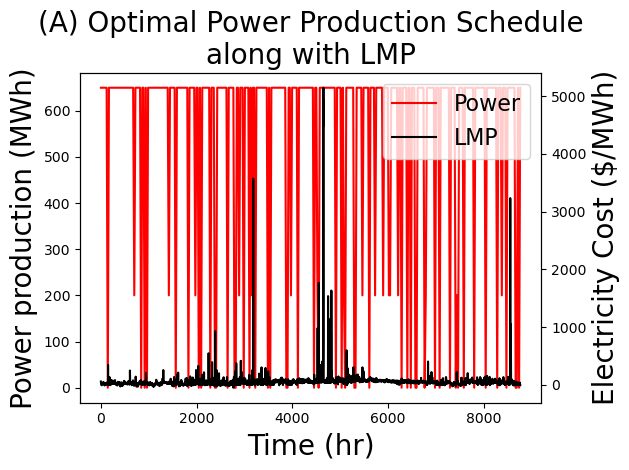

In [64]:
# Gather LMP data for plotting
LMP_data = pd.read_csv(Path("lmp_data.csv"))

power_vals = []
y_vals = []
w_vals = []
v_vals = []

# Extract model data from operation model blocks
for d in range(365):
    # Loop over days in year
    # Access first horizon for each day
    #power_vals.append(pyo.value(m.mp_model.period[i + 1].op_blk.power))
    power_vals.append(pyo.value(m.period[d + 1, 1].op_blk.power))
    y_vals.append(pyo.value(m.period[d + 1, 1].op_blk.op_mode))    
    w_vals.append(pyo.value(m.period[d + 1, 1].op_blk.startup))
    v_vals.append(pyo.value(m.period[d + 1, 1].op_blk.shutdown))

# Plot simultaneous LMP and operating schedule
# Plot example LMP function

fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(np.linspace(0, 8759, 365), power_vals[:], color='r', label='Power') # daily data
ax2.plot(np.arange(8760), LMP_data['ERCOT_WEST_2022'][:], color='k', label='LMP') # hourly data
# ax.set_ylim([-50, 1000])
# ax2.set_ylim([-50, 1000])

ax.set_xlabel("Time (hr)", fontsize=20)
ax2.set_ylabel("Electricity Cost ($/MWh)", fontsize=20)
ax.set_ylabel("Power production (MWh)", fontsize=20)


#ax.plot(np.arange(1000, 1800, 1), power_vals[1000:1800:1], color='r', label='Power')
#ax.set_ylim([-50, 1000])
#ax2.plot(np.arange(1000, 1800, 10), LMP_data['ERCOT_WEST_2022'][1000:1800:10], color='k', label='LMP')
#ax2.set_ylim([-50, 150])

#ax.set_xlabel("Time (hr)", fontsize=20)
#ax2.set_ylabel("Electricity Cost ($/MWh)", fontsize=20)
#ax.set_ylabel("Power production (MWh)", fontsize=20)


ax.set_title("(A) Optimal Power Production Schedule\nalong with LMP", fontsize=20)

l1, lab1 = ax.get_legend_handles_labels()
l2, lab2 = ax2.get_legend_handles_labels()
ax2.legend(l1 + l2, lab1 + lab2, fontsize=16)

plt.tight_layout()
plt.show()

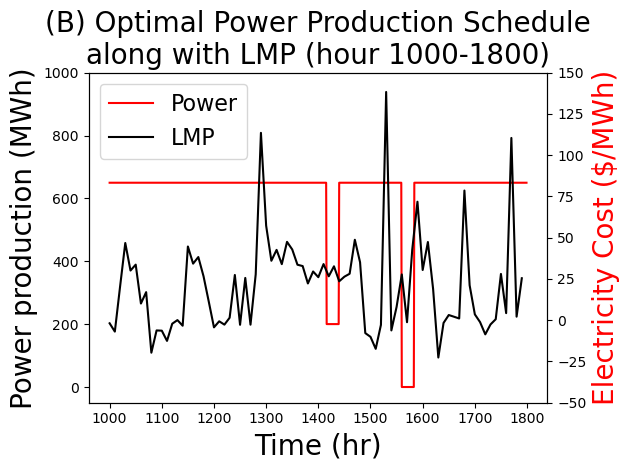

In [65]:
hourly_power_vals = np.repeat(power_vals, 24)

fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(np.arange(1000, 1800, 1), hourly_power_vals[1000:1800:1], color='r', label='Power')
ax.set_ylim([-50, 1000])
ax2.plot(np.arange(1000, 1800, 10), LMP_data['ERCOT_WEST_2022'][1000:1800:10], color='k', label='LMP')
ax2.set_ylim([-50, 150])

# Labels and Titles
ax.set_xlabel("Time (hr)", fontsize=14)
ax.set_ylabel("Electricity Cost ($/MWh)", fontsize=14, color='k')
ax2.set_ylabel("Power production (MWh)", fontsize=14, color='r')

ax.set_xlabel("Time (hr)", fontsize=20)
ax2.set_ylabel("Electricity Cost ($/MWh)", fontsize=20)
ax.set_ylabel("Power production (MWh)", fontsize=20)


ax.set_title("(B) Optimal Power Production Schedule\nalong with LMP (hour 1000-1800)", fontsize=20)

l1, lab1 = ax.get_legend_handles_labels()
l2, lab2 = ax2.get_legend_handles_labels()
ax2.legend(l1 + l2, lab1 + lab2, fontsize=16)

plt.tight_layout()
plt.show()


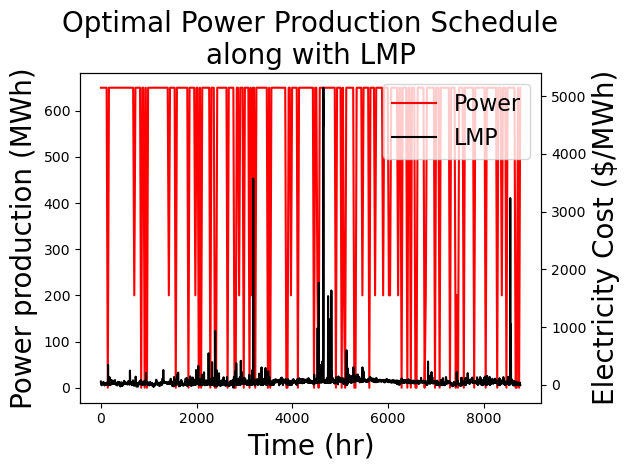

In [54]:
# Gather LMP data for plotting
LMP_data = pd.read_csv(Path("lmp_data.csv"))

power_vals = []
y_vals = []
w_vals = []
v_vals = []

# Extract model data from operation model blocks
for d in range(365):
    # Loop over days in year
    # Access first horizon for each day
    #power_vals.append(pyo.value(m.mp_model.period[i + 1].op_blk.power))
    power_vals.append(pyo.value(m.period[d + 1, 1].op_blk.power))
    y_vals.append(pyo.value(m.period[d + 1, 1].op_blk.op_mode))    
    w_vals.append(pyo.value(m.period[d + 1, 1].op_blk.startup))
    v_vals.append(pyo.value(m.period[d + 1, 1].op_blk.shutdown))

# Plot simultaneous LMP and operating schedule
# Plot example LMP function

fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(np.linspace(0, 8759, 365), power_vals[:], color='r', label='Power') # daily data
ax2.plot(np.arange(8760), LMP_data['ERCOT_WEST_2022'][:], color='k', label='LMP') # hourly data
# ax.set_ylim([-50, 1000])
# ax2.set_ylim([-50, 1000])

ax.set_xlabel("Time (hr)", fontsize=20)
ax2.set_ylabel("Electricity Cost ($/MWh)", fontsize=20)
ax.set_ylabel("Power production (MWh)", fontsize=20)


#ax.plot(np.arange(1000, 1800, 1), power_vals[1000:1800:1], color='r', label='Power')
#ax.set_ylim([-50, 1000])
#ax2.plot(np.arange(1000, 1800, 10), LMP_data['ERCOT_WEST_2022'][1000:1800:10], color='k', label='LMP')
#ax2.set_ylim([-50, 150])

#ax.set_xlabel("Time (hr)", fontsize=20)
#ax2.set_ylabel("Electricity Cost ($/MWh)", fontsize=20)
#ax.set_ylabel("Power production (MWh)", fontsize=20)


ax.set_title("Optimal Power Production Schedule\nalong with LMP", fontsize=20)

l1, lab1 = ax.get_legend_handles_labels()
l2, lab2 = ax2.get_legend_handles_labels()
ax2.legend(l1 + l2, lab1 + lab2, fontsize=16)

plt.tight_layout()
plt.show()


In [52]:
print(len(power_vals[:]))
print(len(power_vals[0:365:1]))  # Ensure we stay within the valid index range

print(len(LMP_data['ERCOT_WEST_2022'][:]))


365
365
8760
